In [1]:
import graph_tool as gt

from graph_tool.all import graph_draw

import inspect
from itertools import combinations
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path, PosixPath

import pandas as pd
import scipy
#User
import pynetio as mio
from myitertools import exhaust, forp
import predicates as pred
from utils import doc, ls, psrc

home = Path.home()

if Path(".").absolute() == PosixPath('/home/aji/Projects/dev/pynet/pyext'):
    src = Path(".")
else:
    src = home / 'Projects/dev/pynet'
data = src / 'data'
lip = data / 'sars-cov-2-LiP'
multi = data / 'multi-proteomics'
apms_stuk = multi / '41586_2021_3493_MOESM6_ESM.xlsx'
apms_stuk_sheetname = 'A - Significant interactions'
apms_gordon = data / 'sars-cov-2-ppi/41586_2020_2286_MOESM5_ESM.xlsx'

#Variables for testing lip funcitons

xls_paths = list(mio.gen_excelpaths_from_dir(lip))
lip1 = xls_paths[1]

lipgen = mio.parse_lip_xls_file(lip1)

apms = pd.read_excel(apms_gordon)


def spec_counts_str_col_to_array(sc):
    def sc_row_to_list(scrow):
        mylist = []
        for i in scrow.split('|'):
            mylist.append(int(i))
        return mylist
    row_list = []
    for row in sc:
        row_list.append(sc_row_to_list(row))
    return np.array(row_list, dtype=np.uint8)

def filter_out_prey(apms):
    return apms[apms['SaintScore'] != 0]


def apms_pre_processing(apms):
    apms = apms.copy()
    apms[['scr1', 'scr2', 'scr3']]=spec_counts_str_col_to_array(apms['Spec'])
    apms = filter_out_prey(apms)
    
    apms['log10 p(prey|sc)'] = np.log10(apms['SaintScore'])
    return apms

apms = apms_pre_processing(apms)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


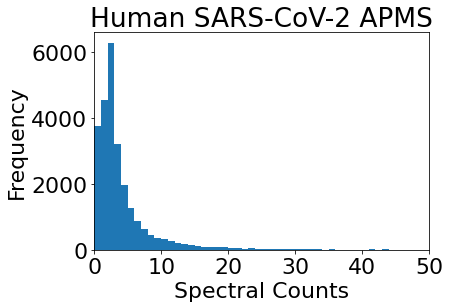

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


#The histogram of spectral counts
plt.hist(np.ravel(list(apms[i].values for i in ['scr1', 'scr2', 'scr3'])), bins=250)
plt.title("Human SARS-CoV-2 APMS")
plt.xlabel('Spectral Counts')
plt.xlim(0, 50)
plt.ylabel("Frequency")
plt.show()

In [3]:
from score import (femax,
                   edge_combs,
                   ne,
                   generate_graph,
                   base,
                   mantissa)
vmax = 6
emax = femax(vmax)
solutions = 2**emax
print('solutions {:.1E}'.format(solutions))
print('gid >= base')
print('gid = base + mantissa')
y = list(edge_combs(emax))
print(y)
print('gid ne base mantissa  graph')

if solutions <= 10000:
    for i in range(2**emax):
        nedges = ne(i, vmax)
        g = generate_graph(i, vmax)
        def pf():
            print(f'{i}   {ne(i, vmax)}   {base(nedges, vmax)}\t{mantissa(i, vmax)}  {g}')
        if solutions <= 256:
            pf()
        elif solutions > 256:
            if solutions % 1000 == 0: pf()

solutions 3.3E+04
gid >= base
gid = base + mantissa
[1, 15, 105, 455, 1365, 3003, 5005, 6435, 6435, 5005, 3003, 1365, 455, 105, 15, 1]
gid ne base mantissa  graph


In [4]:
import score

In [12]:
x = score.PoissonSQRGM(np.array([0, 1, 2]), np.array([[0, 1, 0],
                                                     [1, 1, 0],
                                                     [0, 0, 1]]))

In [14]:
x.phi

array([[0, 1, 0],
       [1, 1, 0],
       [0, 0, 1]])

In [5]:
def all_degrees(g):
    """
    g: undirected graph
    return: an array of degrees
    """
    return np.array(list(v.out_degree() for v in g.vertices()), dtype=int)

In [6]:
score.ugraph_from_elist(generate_graph(99, 100))

OverflowError: cannot convert float infinity to integer

In [7]:
generate_graph(1, 10)

AssertionError: 

In [8]:
np.array((v.out_degree() for v in g.vertices()), dtype=int)

NameError: name 'g' is not defined

In [9]:
g = score.ugraph_from_elist(g)

NameError: name 'g' is not defined

In [10]:
v = g.vertex(0)

NameError: name 'g' is not defined

In [11]:
v.in_degree()

NameError: name 'v' is not defined

In [28]:
v.out_degree()

4

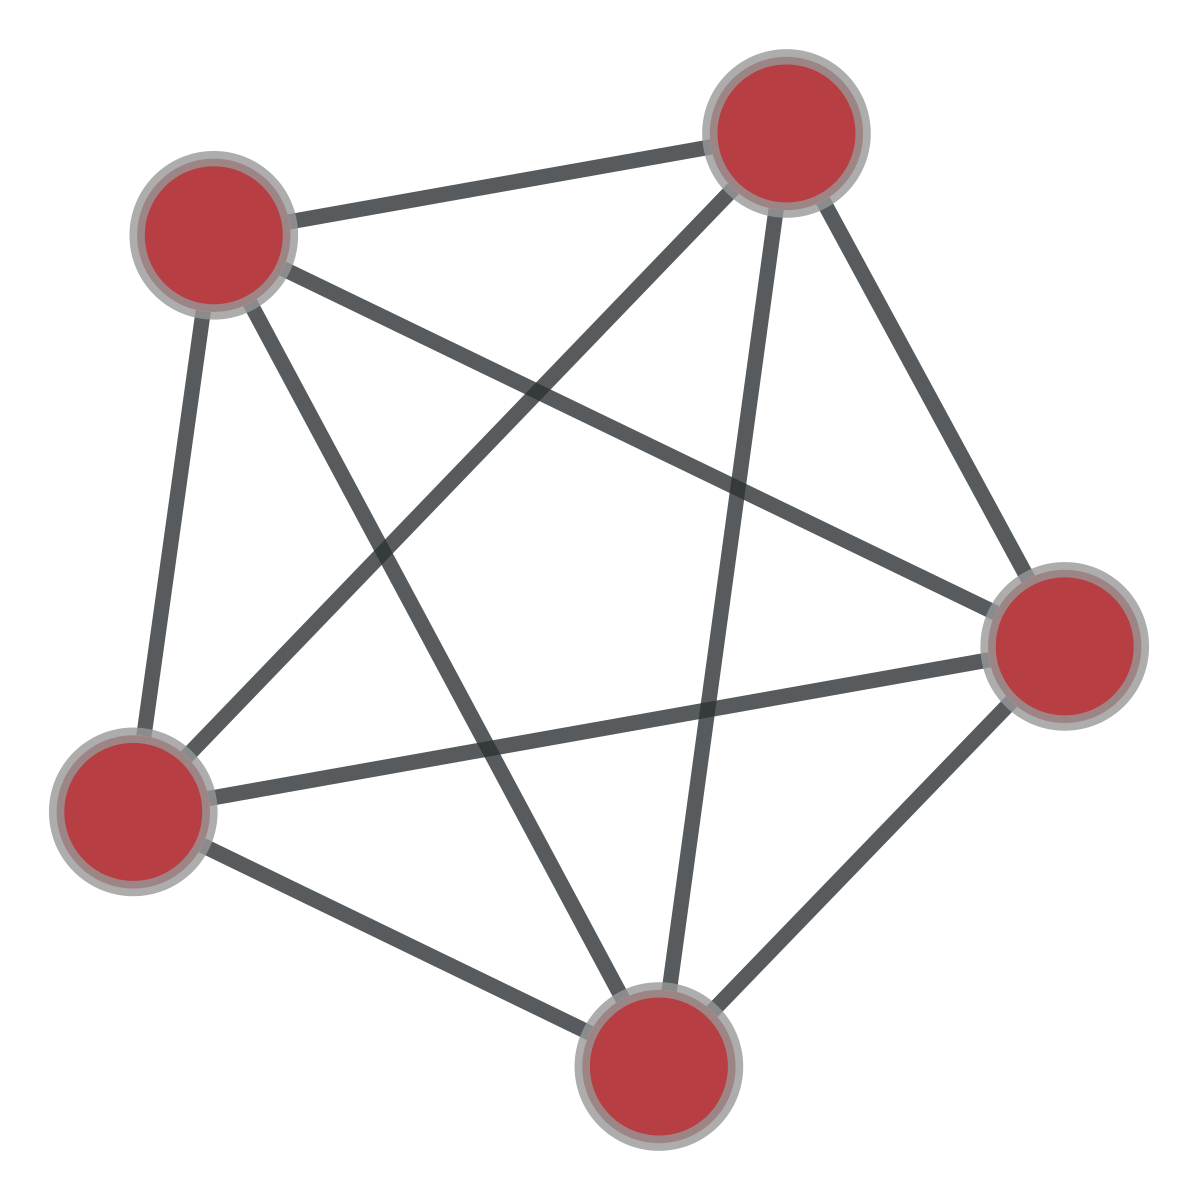

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f33f02af670, at 0x7f33f0279c40>

In [29]:
score.graph_draw(g)

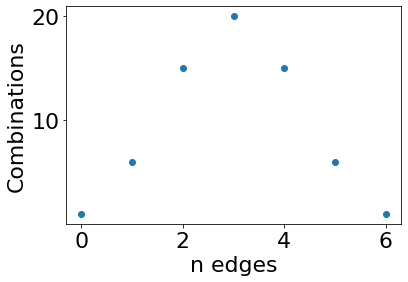

In [9]:
plt.scatter(range(len(y)), y)
plt.xlabel('n edges')
plt.ylabel('Combinations')
plt.show()

In [10]:
def score_functor(M, D):
    return ll_apms(M, D) + lp_apms(M, D)


def rho(x, y):
    """
    Returns the correlation matrix for x and y
    """
    return np.corrcoef(x)

def pc(x, y, z):
    """
    Returns the partial correlation
    x, y, z : rho_xy, rho_xz, rho_zy
    """
    def d(y):
        return np.sqrt(1 - (y)**2)
    return x - y*z / (d(y)*d(z))

def precision(m):
    return -np.linalg.inv(np.corrcoef(C.T))

In [11]:
m = np.random.randint(2, size=(32, 3))
omega = np.cov(m)
#precision = np.linalg.inv(omega)

def thresh(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    elif x==0:
        return 0

In [12]:
def apms_fm(M, D):
    """
    solutions 8.0E+00
    gid >= base
    gid = base + mantissa
    [1, 3, 3, 1]
    gid graph                         rho         upc_01
    0   []                               
    1   [(0, 1)]
    2   [(0, 2)]
    3   [(1, 2)]
    4   [(0, 1), (0, 2)]
    5   [(0, 1), (1, 2)]
    6   [(0, 2), (1, 2)]             02 12 01     upc_01=0  
    7   [(0, 1), (0, 2), (1, 2)]     01, 02, 12,  upc = 0
    
    """
    columns = ['r01', 'r02','r12', 'u01','u02','u12']
    x = np.array([[0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 1, 0, 0],])
    d = pd.DataFrame(x, columns=columns, index='gid')
def ll_apms_triplet(M, D):
    """
    p(d | )
    """

    pass

        

    
    

def ll_apms(M, D):
    """
    XY XZ YZ  g
    +  +  +   xyz, xzy, yzx, xyzx
    +  +  0   xy xz
    +  0  +
    +  -  0
    +  0  -
    +  -  -
    0  0  0
    """

def lp_apms(preyseries,D):
    """
    The log probability
                Preys SaintScore
    preylist : [name, log10 p(prey|spectral counts)]
    The lp will be negative because 0 <= p(prey|sc) < 1
    """
    return sum(preyseries['log10 p(prey|sc)'])

def plot_score():
    """
    Plots the score distributions
    
    """

def test_partial_correlation():
    
    
    
    perms = [(0.9, 0.9, 0.9),
             (0.9, 0.9, 0),
             (0.9, 0.9, 0.7),
            ]
    pcs = list(pc(*i) for i in perms)
    d = pd.DataFrame(perms, columns=['rho_xy', 'rho_xz', 'rho_yz'])
    #d['rho_xy|z']=pcs
    d['upc_xy'] = d.iloc[:, 0] - d.iloc[:, 1]*d.iloc[:, 2]
    d['upc_xz'] = d.iloc[:, 1] - d.iloc[:, 0]*d.iloc[:, 2]
    d['upc_yz'] = d.iloc[:, 2] - d.iloc[:, 1]*d.iloc[:, 0]
    return d
    

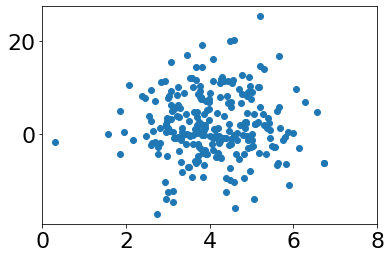

In [13]:
#Fit a bivariate gaussian distribution using gibbs sampling

mu1 = 4.0
sig1 = 1.0
mu2 = 1.7
sig2 = 7
n = 256
x1 = mu1 + sig1*np.random.randn(n)
x2 = mu2 + sig2*np.random.randn(n)
plt.xlim(0, 8)
plt.scatter(x1, x2)

In [14]:
def gibbs_sampler(initial_point, num_samples):
    x_0 = initial_point[0]
    x_1 = initial_point[1]
    samples = np.empty([num_samples+1, 2]) #sampled points
    samples[0] = [x_0, x_1]
    
    for i in range(num_samples):
        
        # Sample from p(x_0|x_1)
        x_0 = conditional_sampler(sampling_index=0, condition_on=x_1, ...)
        # Sample from p(x_1|x_0)
        x_0 = conditional_sampler(sampling_index=1, condition_on=x_0, ...)
        
        samples[i+1] = [x_0, x_1]

    return samples

def conditional_sampler(sampling_index, current_x, mean, cov):
    """
    mean  1x2 vector
    cov:  2x2 positive semidefinite matrx
    """
    conditioned_index = 1 - sampling_index
    #Works because of two variables
    a = cov[sampling_index, sampling_index] #diagonal variance
    b = cov[sampling_index, conditioned_index] #COV[sample, condition]
    c = cov[conditioned_index, conditioned_index] #diagonal variance
    
    mu = mean[sampling_index]
    

SyntaxError: positional argument follows keyword argument (3115005169.py, line 10)

In [11]:
d = 10
x = np.random.poisson(5, d)
sqrtx = np.sqrt(x)
theta = np.random.rand(d)
phi = np.random.rand(d, d)
phi = np.tril(phi)

In [12]:
np.exp(theta.T*sqrtx + np.matmul(np.matmul(sqrtx.T, phi), sqrtx))

array([1.48441212e+62, 1.49951001e+62, 3.19587388e+62, 9.16907789e+61,
       1.78755465e+62, 2.79544757e+62, 1.02779121e+62, 1.91152060e+62,
       1.57870359e+62, 1.09140414e+62])

(array([ 1.,  6., 21., 35., 62., 65., 44., 18.,  2.,  2.]),
 array([0.76948603, 1.41095632, 2.05242662, 2.69389692, 3.33536721,
        3.97683751, 4.61830781, 5.2597781 , 5.9012484 , 6.5427187 ,
        7.18418899]),
 <BarContainer object of 10 artists>)

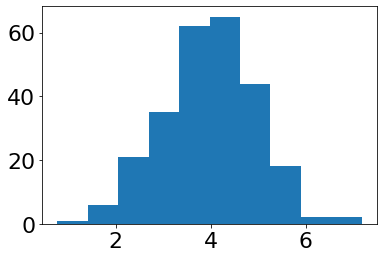

In [13]:
plt.hist(x1)

In [14]:
log_fac_array = np.array(list(np.log(math.factorial(xi)) for xi in range(0, max(x)+1)))
def fac_sum(x):
    rsum = 0
    for xi in x:
        rsum+=log_fac_array[xi]
    return rsum

def poisson_sqr(theta, phi, x):
    sqrtx = np.sqrt(x)
    return np.exp(np.matmul(theta.T, sqrtx) + np.matmul(np.matmul(sqrtx.T, phi), sqrtx) - fac_sum(x))

    
    

NameError: name 'math' is not defined

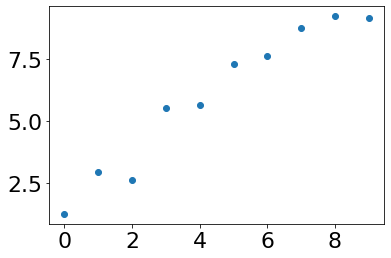

In [15]:
x = np.arange(0, 10)
y = x + 3*np.random.rand(10)
plt.scatter(x, y)

In [16]:
np.corrcoef(x, y)

array([[1.       , 0.9710393],
       [0.9710393, 1.       ]])

Text(0, 0.5, 'frequency')

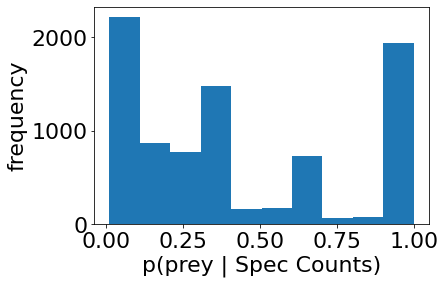

In [17]:
plt.hist(apms['SaintScore'])
plt.xlabel('p(prey | Spec Counts)')
plt.ylabel('frequency')

Text(0, 0.5, 'MIST')

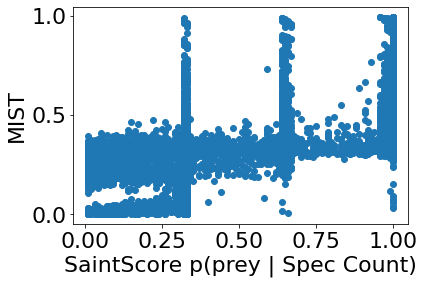

In [19]:
plt.scatter(apms['SaintScore'], apms['MIST'])
plt.xlabel('SaintScore p(prey | Spec Count)')
plt.ylabel('MIST')

In [20]:
def npreys(df, baitname):
    return sum(df['Bait']==baitname)

def gen_apms_n_preys_per_bait(apms):
    for bait in set(apms['Bait']):
        yield (bait, npreys(apms, bait))
npreys = list(gen_apms_n_preys_per_bait(apms))
npreys

[('SARS-CoV2 orf9b', 219),
 ('SARS-CoV2 orf10', 323),
 ('SARS-CoV2 nsp15', 108),
 ('SARS-CoV2 nsp8', 522),
 ('SARS-CoV2 orf9c', 753),
 ('SARS-CoV2 nsp6', 447),
 ('SARS-CoV2 nsp4', 389),
 ('SARS-CoV2 nsp10', 83),
 ('SARS-CoV2 orf3a', 456),
 ('SARS-CoV2 nsp1', 148),
 ('SARS-CoV2 Spike', 327),
 ('SARS-CoV2 N', 238),
 ('SARS-CoV2 orf3b', 250),
 ('SARS-CoV2 nsp14', 85),
 ('SARS-CoV2 M', 589),
 ('SARS-CoV2 orf7a', 363),
 ('SARS-CoV2 nsp7', 296),
 ('SARS-CoV2 E', 323),
 ('SARS-CoV2 orf6', 256),
 ('SARS-CoV2 nsp12', 162),
 ('SARS-CoV2 nsp13', 485),
 ('SARS-CoV2 nsp11', 389),
 ('SARS-CoV2 nsp5', 90),
 ('SARS-CoV2 nsp5_C145A', 40),
 ('SARS-CoV2 nsp9', 220),
 ('SARS-CoV2 nsp2', 434),
 ('SARS-CoV2 orf8', 512)]

In [21]:
t1 = [(0, 1)]
t2 = [(0, 2)]
t3 = [(1, 2)]
t4 = [(0, 1), (0, 2)]
t5 = [(0, 1), (1, 2)]
t6 = [(0, 1), (0, 2), (1, 2)]

#
t3_4 = [(0, 3)]


master = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


tests = {3:[t1, t2, t3, t4, t5, t6],
         4:[[(0, 1)], #4 1 6 1 : 1 : master[gid-1]
            [(0, 2)], #4 1 6 2 : 2
            [(0, 3)], #4 1 6 3 : 3
            [(1, 2)], #4 1 6 4 : 4
            [(1, 3)], #4 1 6 5 : 5
            [(2, 3)], #4 1 6 6 : 6
            [(0, 1), (0, 2)], #4 2 5 1 : 7 master[0:gid] = master[]
            [(0, 1), (0, 3)], #4 2 5 2 : 8
            [(0, 1), (1, 2)], #4 2 5 3 : 9
            [(0, 1), (1, 3)], #4 2 5 4 : 10
            [(0, 1), (2, 3)], #4 2 5 5 : 11
            [(0, 2), (0, 3)], #4 2 4 1 : 12 master[1:gid]
            [(0, 2), (1, 2)], #
            [(0, 2), (1, 3)],
            [(0, 2), (2, 3)],
            [(0, 3), (1, 2)],
            [(0, 3), (1, 3)],
            [(0, 3), (2, 3)],
            [(1, 2), (1, 3)],
            [(1, 2), (2, 3)],
            [(1, 3), (2, 3)],
            [(0, 1), (0, 2), (0, 3)],
            [(0, 1), (0, 2), (1, 2)],
            [(0, 1), (0, 2), (1, 3)],
            [(0, 1), (0, 2), (2, 3)],
            [(0, 1), (0, 3), (1, 2)],
            [(0, 1), (0, 3), (1, 3)],
            [(0, 1), (0, 3), (2, 3)]
            [(0, 1), (0, 2), (0, 3), (1, 2)]
           ]}


# 4 choose 2
# 1, 2 | 1, 3 | 1

for key, item in tests.items():
    print('\n')
    for i, test in enumerate(item):
        result = next_n_graph(test, key)
        try:
            compare = result == item[i+1]
        except IndexError:
            compare = "IndexError"
        print(f'key:{key} test:{test} return: {result} compare: {compare}')

<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_337266/4033629585.py:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [(0, 1), (0, 3), (2, 3)]


TypeError: list indices must be integers or slices, not tuple

In [22]:
# (0, 1) ne
# (0, 2) ne
# (1, 2)

# (0, 1), (0, 2) ne
# (0, 1), (1, 2) ne
# (0, 2), (1, 2)

# (0, 1), (0, 2), (1, 2)


# (0, 1)
# (0, 2)
# (0, 3)
# (1, 2)
# (1, 3)
# (2, 3)

# (0, 1), (0, 2)
# (0, 1), (0, 3)
# (0, 1), (1, 2)
# (0, 1), (1, 3)
# (0, 1), (2, 3)

# (0, 2), (0, 3)
# (0, 2), (1, 2) ...


# (0, 1), (0, 2), (0, 3)
# (0, 1), (0, 2), (1, 2)
# (0, 1), (0, 2), (1, 3)
# (0, 1), (0, 2), (2, 3)

# (0, 1), (0, 3), (1, 2)
# (0, 1), (0, 3), (1, 3)
# (0, 1), (0, 3), (2, 3)

# (0, 1), (1, 2), (1, 3)
# (0, 1), (1, 2), (2, 3)
# (0, 1), (1, 3), (2, 3)

# (0, 1), (2,3), (3, 4) #reject


In [23]:
#Introduce Integrative Network Modeling
#Motivate the problem, emphasis on generalizability

#Illustration with APMS data likelihood and prior

#Prior based on graph density -> Benchmark on Corum

#Likelihood based on the covariation of abundances in APMS data

#Comparison to know complexes in Corum

#Prior predictive check

#Next steps